----

## **Smart Hiring Dashboard for Startups – Analyzing Job Application Funnel Efficiency**
---
### **1. Import Required Libraries**

In [59]:
import pandas as pd
import numpy as np
from faker import Faker
import random
from datetime import datetime, timedelta
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### **2. Initialize Faker**

In [60]:
fake = Faker()

### **3. Set seed for reproducibility**

In [61]:
np.random.seed(42)
random.seed(42)

----
### **4. Define possible values**

In [62]:
roles = ['Software Engineer', 'Data Scientist', 'Product Manager', 'HR Manager', 'Sales Executive', 'Marketing Specialist']
departments = ['Tech', 'HR', 'Sales', 'Marketing', 'Product']
sources = ['LinkedIn', 'Naukri', 'AngelList', 'Referral', 'Company Website']
statuses = ['Hired', 'Rejected', 'Dropped']

---

### **5. Generate dataset**

In [63]:
n_records = 10000
data = {
    'Candidate_ID': [f'C{str(i).zfill(5)}' for i in range(1, n_records + 1)],
    'Role_Applied': [random.choice(roles) for _ in range(n_records)],
    'Department': [random.choice(departments) for _ in range(n_records)],
    'Source': [random.choice(sources) for _ in range(n_records)],
    'Application_Date': [fake.date_between(start_date='-2y', end_date='today') for _ in range(n_records)],
    'Screening_Date': [None] * n_records,
    'Interview_Date': [None] * n_records,
    'Offer_Date': [None] * n_records,
    'Hire_Date': [None] * n_records,
    'Final_Status': [random.choice(statuses) for _ in range(n_records)]
}

---
### **6. Create DataFrame**

In [64]:
df = pd.DataFrame(data)

---
### **7. Introduce duplicates (5% of records)**

In [65]:
n_duplicates = int(n_records * 0.01)
duplicate_indices = np.random.choice(df.index, size=n_duplicates, replace=False)
for idx in duplicate_indices:
    df.loc[n_records + idx] = df.loc[idx]
df = df.reset_index(drop=True)

----
### **8. Introduce missing values (10% missing for dates)**

In [66]:
for col in ['Screening_Date', 'Interview_Date', 'Offer_Date', 'Hire_Date']:
    mask = np.random.choice(df.index, size=int(n_records * 0.01), replace=False)
    df.loc[mask, col] = np.nan

----
### **9. Fill dates with progression logic and introduce invalid dates**

In [67]:
for i in range(len(df)):
    app_date = df.loc[i, 'Application_Date']
    if pd.notnull(app_date):
        # Screening date: 1-10 days after application
        if random.random() > 0.1:  # 90% chance of having a screening date
            df.loc[i, 'Screening_Date'] = app_date + timedelta(days=random.randint(1, 10))
        
        # Interview date: 1-15 days after screening
        if pd.notnull(df.loc[i, 'Screening_Date']) and random.random() > 0.2:
            df.loc[i, 'Interview_Date'] = df.loc[i, 'Screening_Date'] + timedelta(days=random.randint(1, 15))
        
        # Offer date: 1-10 days after interview
        if pd.notnull(df.loc[i, 'Interview_Date']) and random.random() > 0.3:
            df.loc[i, 'Offer_Date'] = df.loc[i, 'Interview_Date'] + timedelta(days=random.randint(1, 10))
        
        # Hire date: 1-20 days after offer, only if hired
        if pd.notnull(df.loc[i, 'Offer_Date']) and df.loc[i, 'Final_Status'] == 'Hired':
            df.loc[i, 'Hire_Date'] = df.loc[i, 'Offer_Date'] + timedelta(days=random.randint(1, 20))

### **10. Introduce invalid dates (5% of records)**

In [68]:
invalid_date_indices = np.random.choice(df.index, size=int(n_records * 0.01), replace=False)
for idx in invalid_date_indices:
    col = random.choice(['Application_Date', 'Screening_Date', 'Interview_Date', 'Offer_Date', 'Hire_Date'])
    if pd.notnull(df.loc[idx, col]):
        df.loc[idx, col] = '9999-99-99'  # Invalid date

--

### **11. Save to CSV**

In [69]:
df.to_csv('hiring_dataset.csv', index=False)

print("Dataset generated and saved as 'hiring_dataset.csv' with 1000 records, including duplicates, missing values, and invalid dates.")

Dataset generated and saved as 'hiring_dataset.csv' with 1000 records, including duplicates, missing values, and invalid dates.


--

### **12. Load the dataset**

In [70]:
df = pd.read_csv('hiring_dataset.csv')

#### **Step 1: Remove duplicates based on Candidate_ID**

In [71]:
df = df.drop_duplicates(subset='Candidate_ID', keep='first')
print(f"Removed duplicates. Dataset size after deduplication: {len(df)}")

Removed duplicates. Dataset size after deduplication: 10000


#### **Step 2: Convert date columns to datetime, handling invalid dates**

In [72]:
date_columns = ['Application_Date', 'Screening_Date', 'Interview_Date', 'Offer_Date', 'Hire_Date']
for col in date_columns:
    # Replace invalid dates (e.g., '9999-99-99') with NaT
    df[col] = pd.to_datetime(df[col], errors='coerce')

#### **Step 3: Handle missing dates logically**
- `Flag rows where Hire_Date is present but Offer_Date is missing`

In [73]:
df['Missing_Offer_Flag'] = (df['Hire_Date'].notnull() & df['Offer_Date'].isnull())

# Impute missing dates where possible
for i, row in df.iterrows():
    if row['Missing_Offer_Flag']:
        # If Hire_Date exists but Offer_Date is missing, impute Offer_Date as 5 days before Hire_Date
        df.loc[i, 'Offer_Date'] = row['Hire_Date'] - pd.Timedelta(days=5)
    
    # If Interview_Date is missing but Offer_Date exists, impute Interview_Date as 7 days before Offer_Date
    if pd.notnull(row['Offer_Date']) and pd.isnull(row['Interview_Date']):
        df.loc[i, 'Interview_Date'] = row['Offer_Date'] - pd.Timedelta(days=7)
    
    # If Screening_Date is missing but Interview_Date exists, impute Screening_Date as 7 days before Interview_Date
    if pd.notnull(row['Interview_Date']) and pd.isnull(row['Screening_Date']):
        df.loc[i, 'Screening_Date'] = row['Interview_Date'] - pd.Timedelta(days=7)

#### **Step 4: Add calculated column**

In [74]:
df['Time_to_Hire'] = (df['Hire_Date'] - df['Application_Date']).dt.days
# Replace NaN with -1 for non-hired candidates
df['Time_to_Hire'] = df['Time_to_Hire'].fillna(-1).astype(int)

#### **Step 5: Add calculated column**

In [75]:
def determine_stage_drop(row):
    if row['Final_Status'] == 'Hired':
        return 'None'  # No drop if hired
    elif pd.notnull(row['Hire_Date']):
        return 'None'  # Safety check for hired candidates
    elif pd.notnull(row['Offer_Date']):
        return 'After_Offer'
    elif pd.notnull(row['Interview_Date']):
        return 'After_Interview'
    elif pd.notnull(row['Screening_Date']):
        return 'After_Screening'
    elif pd.notnull(row['Application_Date']):
        return 'After_Application'
    else:
        return 'No_Application'

df['Stage_Drop'] = df.apply(determine_stage_drop, axis=1)

#### **Step 6: Save the cleaned dataset**

In [76]:
print("Cleaned dataset saved as 'cleaned_hiring_dataset.csv'")
print("\nDataset Summary:")
print(f"Total records: {len(df)}")
print(f"Missing Offer_Date flagged: {df['Missing_Offer_Flag'].sum()}")
print(f"Time_to_Hire stats (for hired candidates):")
print(df[df['Final_Status'] == 'Hired']['Time_to_Hire'].describe())
print("\nStage_Drop distribution:")
print(df['Stage_Drop'].value_counts())

Cleaned dataset saved as 'cleaned_hiring_dataset.csv'

Dataset Summary:
Total records: 10000
Missing Offer_Date flagged: 4
Time_to_Hire stats (for hired candidates):
count    3297.000000
mean       14.483470
std        16.425466
min        -1.000000
25%        -1.000000
50%        11.000000
75%        30.000000
max        53.000000
Name: Time_to_Hire, dtype: float64

Stage_Drop distribution:
Stage_Drop
After_Offer          3388
None                 3297
After_Interview      1411
After_Screening      1228
After_Application     675
No_Application          1
Name: count, dtype: int64


### **13. Set Seaborn style**

In [77]:
sns.set(style="whitegrid")

-
### **14. Load the cleaned dataset**

In [78]:
df = pd.read_csv('cleaned_hiring_dataset.csv')

---
### **15. Convert date columns to datetime**

In [79]:
date_columns = ['Application_Date', 'Screening_Date', 'Interview_Date', 'Offer_Date', 'Hire_Date']
for col in date_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')

---

### **16. Initialize markdown content for insights**

In [80]:
insights = []

#### **a). Analyze drop-off stages**

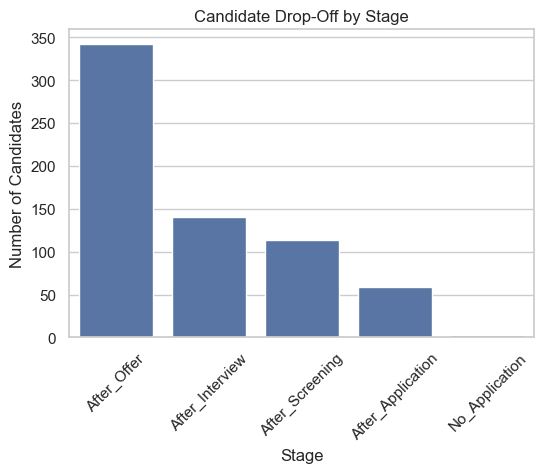

In [81]:
drop_off_counts = df['Stage_Drop'].value_counts()
insights.append("## Drop-Off Stages\n")
insights.append(f"The most drop-offs occur at the following stages:\n{drop_off_counts.to_string()}\n")
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Stage_Drop', order=drop_off_counts.index)
plt.title('Candidate Drop-Off by Stage')
plt.xlabel('Stage')
plt.ylabel('Number of Candidates')
plt.xticks(rotation=45)
plt.savefig('drop_off_stages.png')
plt.show()
plt.close()

#### **b). Number of applicants by role, source, and department**
#### **Applicants by Role**

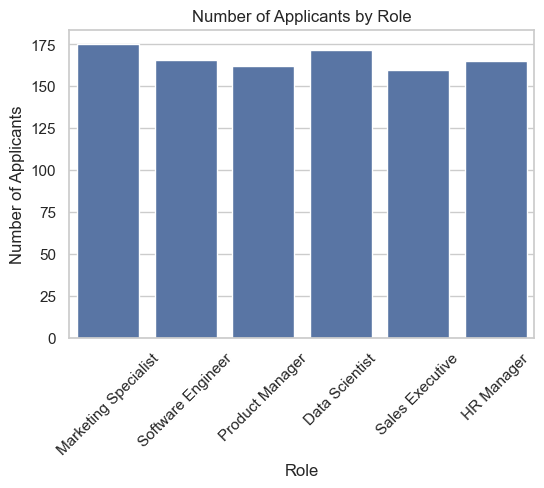

In [82]:
applicants_by_role = df['Role_Applied'].value_counts()
insights.append("## Applicants by Role\n")
insights.append(f"{applicants_by_role.to_string()}\n")
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Role_Applied')
plt.title('Number of Applicants by Role')
plt.xlabel('Role')
plt.ylabel('Number of Applicants')
plt.xticks(rotation=45)
plt.savefig('applicants_by_role.png')
plt.show()
plt.close()

#### **Applicants by Source**

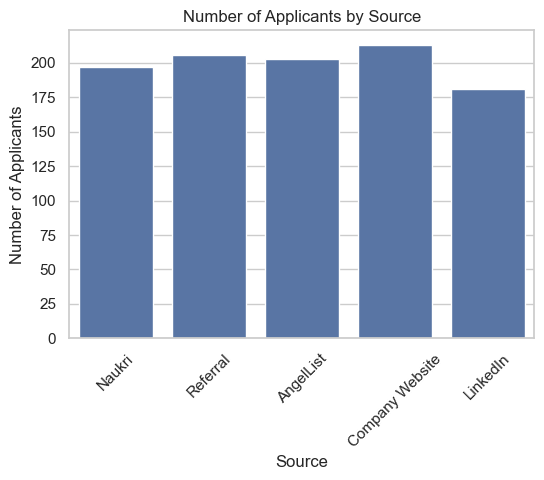

In [83]:
applicants_by_source = df['Source'].value_counts()
insights.append("## Applicants by Source\n")
insights.append(f"{applicants_by_source.to_string()}\n")
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Source')
plt.title('Number of Applicants by Source')
plt.xlabel('Source')
plt.ylabel('Number of Applicants')
plt.xticks(rotation=45)
plt.savefig('applicants_by_source.png')
plt.show()
plt.close()

#### **Applicants by Department**

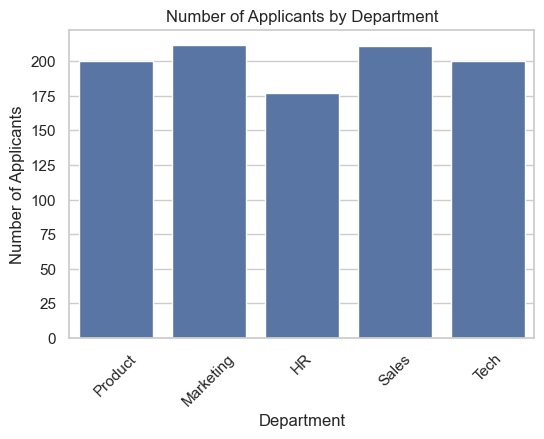

In [84]:
applicants_by_department = df['Department'].value_counts()
insights.append("## Applicants by Department\n")
insights.append(f"{applicants_by_department.to_string()}\n")
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Department')
plt.title('Number of Applicants by Department')
plt.xlabel('Department')
plt.ylabel('Number of Applicants')
plt.xticks(rotation=45)
plt.savefig('applicants_by_department.png')
plt.show()
plt.close()

#### **4. Drop-off heatmap by department and stage**

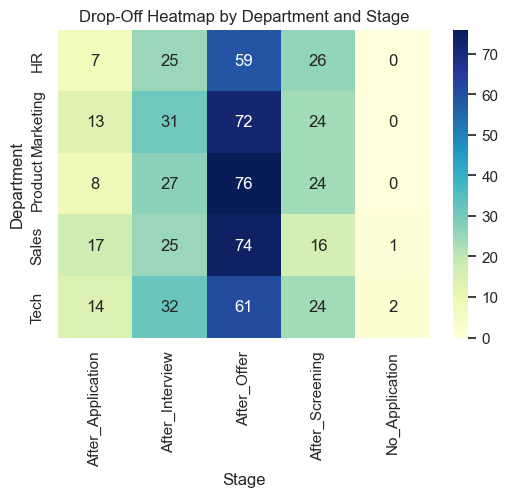

In [85]:
heatmap_data = df.groupby(['Department', 'Stage_Drop']).size().unstack(fill_value=0)
insights.append("## Drop-Off Heatmap by Department and Stage\n")
insights.append("Heatmap shows the number of candidates dropping off at each stage by department.\n")
plt.figure(figsize=(6, 4))
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Drop-Off Heatmap by Department and Stage')
plt.xlabel('Stage')
plt.ylabel('Department')
plt.savefig('drop_off_heatmap.png')
plt.show()
plt.close()

----
### **17. Save insights to markdown file**

In [86]:
with open('eda_insights.md', 'w') as f:
    f.write('\n'.join(insights))

print("EDA completed. Insights saved to 'eda_insights.md' and plots saved as PNG files.")

EDA completed. Insights saved to 'eda_insights.md' and plots saved as PNG files.


In [87]:
import sqlite3
from datetime import datetime

### **18. Load the cleaned dataset**

In [88]:
df = pd.read_csv('cleaned_hiring_dataset.csv')

### **19. Convert date columns to string format for SQL compatibility**

In [ ]:
date_columns = ['Application_Date', 'Screening_Date', 'Interview_Date', 'Offer_Date', 'Hire_Date']
for col in date_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce').dt.strftime('%Y-%m-%d')

----

### **20. Connect to SQLite database**

In [ ]:
conn = sqlite3.connect('hiring_database.db')
cursor = conn.cursor()

----
### **21. Create Database Schema**

In [ ]:
cursor.executescript('''
    DROP TABLE IF EXISTS candidates;
    DROP TABLE IF EXISTS applications;
    DROP TABLE IF EXISTS stages;

    CREATE TABLE candidates (
        candidate_id TEXT PRIMARY KEY,
        role_applied TEXT,
        department TEXT
    );

    CREATE TABLE applications (
        application_id INTEGER PRIMARY KEY AUTOINCREMENT,
        candidate_id TEXT,
        source TEXT,
        application_date DATE,
        FOREIGN KEY (candidate_id) REFERENCES candidates(candidate_id)
    );

    CREATE TABLE stages (
        stage_id INTEGER PRIMARY KEY AUTOINCREMENT,
        candidate_id TEXT,
        screening_date DATE,
        interview_date DATE,
        offer_date DATE,
        hire_date DATE,
        final_status TEXT,
        missing_offer_flag BOOLEAN,
        time_to_hire INTEGER,
        stage_drop TEXT,
        FOREIGN KEY (candidate_id) REFERENCES candidates(candidate_id)
    );
''')


-

### **22. Insert data into tables**

#### **Candidates table**

In [ ]:
candidates_df = df[['Candidate_ID', 'Role_Applied', 'Department']].drop_duplicates()
candidates_df.to_sql('candidates', conn, if_exists='append', index=False)

#### **Applications table**

In [ ]:
applications_df = df[['Candidate_ID', 'Source', 'Application_Date']]
applications_df.to_sql('applications', conn, if_exists='append', index=False)

#### **Stages table**

In [ ]:
stages_df = df[['Candidate_ID', 'Screening_Date', 'Interview_Date', 'Offer_Date', 'Hire_Date', 
                'Final_Status', 'Missing_Offer_Flag', 'Time_to_Hire', 'Stage_Drop']]
stages_df.to_sql('stages', conn, if_exists='append', index=False)

-

### **23. SQL Queries for Aggregations**
#### **Query 1: Drop-off counts and percentages**

In [ ]:

drop_off_query = '''
WITH drop_off_counts AS (
    SELECT stage_drop, COUNT(*) as drop_count
    FROM stages
    GROUP BY stage_drop
),
total_candidates AS (
    SELECT COUNT(*) as total
    FROM stages
)
SELECT 
    d.stage_drop,
    d.drop_count,
    ROUND((d.drop_count * 100.0 / t.total), 2) as percentage
FROM drop_off_counts d
CROSS JOIN total_candidates t
ORDER BY d.drop_count DESC;
'''
drop_off_df = pd.read_sql_query(drop_off_query, conn)
drop_off_df.to_csv('drop_off_summary.csv', index=False)

#### **Query 2: Conversion rates between stages**

In [ ]:
conversion_query = '''
WITH stage_counts AS (
    SELECT 
        SUM(CASE WHEN application_date IS NOT NULL THEN 1 ELSE 0 END) as applied,
        SUM(CASE WHEN screening_date IS NOT NULL THEN 1 ELSE 0 END) as screened,
        SUM(CASE WHEN interview_date IS NOT NULL THEN 1 ELSE 0 END) as interviewed,
        SUM(CASE WHEN offer_date IS NOT NULL THEN 1 ELSE 0 END) as offered,
        SUM(CASE WHEN hire_date IS NOT NULL THEN 1 ELSE 0 END) as hired
    FROM stages s
    JOIN applications a ON s.candidate_id = a.candidate_id
)
SELECT 
    applied,
    screened,
    ROUND((screened * 100.0 / applied), 2) as application_to_screening_pct,
    interviewed,
    ROUND((interviewed * 100.0 / screened), 2) as screening_to_interview_pct,
    offered,
    ROUND((offered * 100.0 / interviewed), 2) as interview_to_offer_pct,
    hired,
    ROUND((hired * 100.0 / offered), 2) as offer_to_hire_pct
FROM stage_counts;
'''
conversion_df = pd.read_sql_query(conversion_query, conn)
conversion_df.to_csv('conversion_rates.csv', index=False)

#### **Query 3: Average time-to-hire per role**

In [ ]:
time_to_hire_query = '''
SELECT 
    c.role_applied,
    AVG(s.time_to_hire) as avg_time_to_hire,
    COUNT(s.time_to_hire) as hired_count
FROM stages s
JOIN candidates c ON s.candidate_id = c.candidate_id
WHERE s.final_status = 'Hired' AND s.time_to_hire >= 0
GROUP BY c.role_applied
ORDER BY avg_time_to_hire DESC;
'''
time_to_hire_df = pd.read_sql_query(time_to_hire_query, conn)
time_to_hire_df.to_csv('time_to_hire_by_role.csv', index=False)

#### **Query 4: Source performance**

In [ ]:
source_performance_query = '''
WITH source_stats AS (
    SELECT 
        a.source,
        COUNT(*) as total_applications,
        SUM(CASE WHEN s.final_status = 'Hired' THEN 1 ELSE 0 END) as hired_count,
        ROW_NUMBER() OVER (ORDER BY SUM(CASE WHEN s.final_status = 'Hired' THEN 1 ELSE 0 END) DESC) as rank
    FROM applications a
    JOIN stages s ON a.candidate_id = s.candidate_id
    GROUP BY a.source
)
SELECT 
    source,
    total_applications,
    hired_count,
    ROUND((hired_count * 100.0 / total_applications), 2) as hire_rate,
    rank
FROM source_stats
ORDER BY hired_count DESC;
'''
source_performance_df = pd.read_sql_query(source_performance_query, conn)
source_performance_df.to_csv('source_performance.csv', index=False)

--

### **24. Close the connection**

In [ ]:
conn.commit()
conn.close()

print("Database schema created and data stored in 'hiring_database.db'.")
print("Aggregations completed and saved as CSV files: 'drop_off_summary.csv', 'conversion_rates.csv', 'time_to_hire_by_role.csv', 'source_performance.csv'.")

-

### **25. Preview a CSV**

In [ ]:
pd.read_csv('drop_off_summary.csv')

---

### **26. Display a plot**

In [ ]:
from IPython.display import Image
Image('drop_off_heatmap.png')

----

In [ ]:
import sqlite3
conn = sqlite3.connect('hiring_database.db')
query = 'SELECT * FROM candidates LIMIT 7'
df_sample = pd.read_sql_query(query, conn)
print(df_sample)

----
### **27. Install dependencies and Libraries (if not already installed)**

In [ ]:
!pip install pandas numpy faker seaborn matplotlib sqlite3
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

---

### **28. Load the cleaned dataset**

In [ ]:
df = pd.read_csv('cleaned_hiring_dataset.csv')
print("Columns in cleaned_hiring_dataset.csv:")
print(df.columns.tolist())
print("\nFirst 7 rows:")
df.head(7)

---
### **29. Connect to SQLite database and verify tables**

In [ ]:
conn = sqlite3.connect('hiring_database.db')
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
print("Tables in database:", tables)

# List columns in each table
for table in tables:
    table_name = table[0]
    print(f"\nColumns in {table_name}:")
    cursor.execute(f"PRAGMA table_info({table_name});")
    columns = [info[1] for info in cursor.fetchall()]
    print(columns)

----

### **30. Query all columns from all tables**

In [ ]:
query = '''
SELECT c.candidate_id, c.role_applied, c.department, a.source, a.application_date,
       s.screening_date, s.interview_date, s.offer_date, s.hire_date,
       s.final_status, s.missing_offer_flag, s.time_to_hire, s.stage_drop
FROM candidates c
LEFT JOIN applications a ON c.candidate_id = a.candidate_id
LEFT JOIN stages s ON c.candidate_id = s.candidate_id
'''
db_df = pd.read_sql_query(query, conn)
print("\nColumns in joined query:")
print(db_df.columns.tolist())
print("\nFirst 7 rows from database:")
db_df.head(7)

#### **Drop-off counts**

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Stage_Drop', order=df['Stage_Drop'].value_counts().index)
plt.title('Candidate Drop-Off by Stage')
plt.xlabel('Stage')
plt.ylabel('Number of Candidates')
plt.xticks(rotation=45)
plt.show()

#### **Applicants by source**

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Source', order=df['Source'].value_counts().index)
plt.title('Number of Applicants by Source')
plt.xlabel('Source')
plt.ylabel('Number of Applicants')
plt.xticks(rotation=45)
plt.show()

----

### **31. Save the full dataset for Power BI**

In [ ]:
df.to_csv('full_dataset.csv', index=False)
print("Full dataset saved as 'full_dataset.csv'")

---------------